<a href="https://colab.research.google.com/github/SKrishna93/EVA5/blob/master/Week5/EVA5_Session_5_Model4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing torch packages for Neural Network building
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__() 
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False), # Input=28x28x1 Kernel=3x3x1x10 Output=28x28x10 RF=3x3
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False), # Input=28x28x10 Kernel=3x3x10x10 Output=28x28x10 RF=5x5
        nn.ReLU(),
        nn.BatchNorm2d(10)
        ) #output_size=28x28x10
    self.conv2 = nn.Sequential(
        nn.MaxPool2d(kernel_size=2, stride=2), # Input=28x28x10 Output=14x14x10 RF=6x6
        )#output_size=14x14x10

    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), #Input=14x14x10 Kernel=3x3x10x10 Output=12x12x10 RF=10x10
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), #Input=12x12x10 Kernel=3x3x10x12 Output=10x10x12 RF=14x14
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #Input=10x10x12 Kernel=3x3x12x16 Output=8x8x16 RF=18x18
        nn.ReLU(),            
        nn.BatchNorm2d(16),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #Input=8x8x16 Kernel=3x3x16x16 Output=6x6x16 RF=22x22
        nn.ReLU(),         
        nn.BatchNorm2d(16)
        )#output_size=6x6x16

    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #Input=6x6x16 Kernel=3x3x16x16 Output=4x4x16 RF=26x26
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.AvgPool2d(kernel_size=(4,4)), #Input=4x4x16 Kernel=4x4x16x16 Output=1x1x16 RF=????
        nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False) #Input=1x1x16 Kernel=1x1x16x10 Output=1x1x10 RF=?????
        ) 


  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(-1, 10)
    return F.log_softmax(x)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
            Conv2d-4           [-1, 10, 28, 28]             900
              ReLU-5           [-1, 10, 28, 28]               0
       BatchNorm2d-6           [-1, 10, 28, 28]              20
         MaxPool2d-7           [-1, 10, 14, 14]               0
            Conv2d-8           [-1, 10, 12, 12]             900
              ReLU-9           [-1, 10, 12, 12]               0
      BatchNorm2d-10           [-1, 10, 12, 12]              20
           Conv2d-11           [-1, 12, 10, 10]           1,080
             ReLU-12           [-1, 12, 10, 10]               0
      BatchNorm2d-13           [-1, 12, 10, 10]              24
           Conv2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
train_epoch_end = []
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  train_epoch_end.append(train_acc[-1])

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.021186107769608498 Batch_id=937 Accuracy=94.43: 100%|██████████| 938/938 [00:17<00:00, 54.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0548, Accuracy: 9831/10000 (98.31%)

EPOCH: 2


Loss=0.0582580640912056 Batch_id=937 Accuracy=98.05: 100%|██████████| 938/938 [00:17<00:00, 54.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9895/10000 (98.95%)

EPOCH: 3


Loss=0.027025869116187096 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [00:17<00:00, 53.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9902/10000 (99.02%)

EPOCH: 4


Loss=0.16581182181835175 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:17<00:00, 52.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9933/10000 (99.33%)

EPOCH: 5


Loss=0.012608194723725319 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:17<00:00, 53.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9933/10000 (99.33%)

EPOCH: 6


Loss=0.014160536229610443 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:17<00:00, 53.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.07857924699783325 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:17<00:00, 52.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.04120370000600815 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:17<00:00, 53.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9936/10000 (99.36%)

EPOCH: 9


Loss=0.01051598135381937 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:17<00:00, 52.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9944/10000 (99.44%)

EPOCH: 10


Loss=0.028524693101644516 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:17<00:00, 52.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.0018414414953440428 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:17<00:00, 53.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.015570203773677349 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:17<00:00, 52.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.00043407586053945124 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:17<00:00, 53.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9943/10000 (99.43%)

EPOCH: 14


Loss=0.005949454847723246 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:17<00:00, 52.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9941/10000 (99.41%)

EPOCH: 15


Loss=0.0009868836496025324 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:17<00:00, 52.46it/s]



Test set: Average loss: 0.0179, Accuracy: 9941/10000 (99.41%)



Text(0.5, 1.0, 'Test Accuracy')

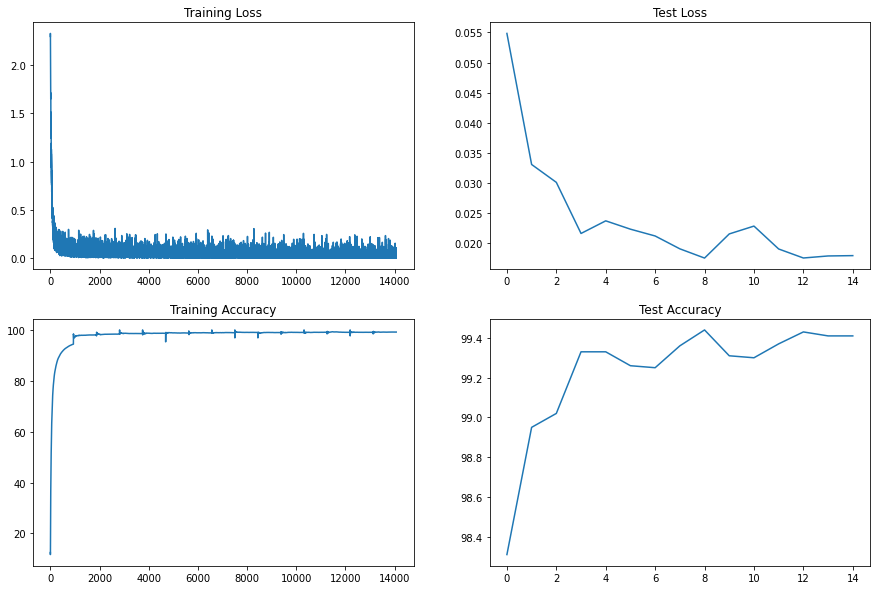

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

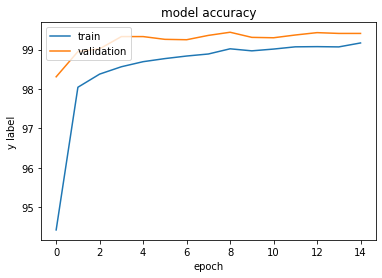

Best Train Accuracy: 99.17%
Best Test Accuracy: 99.44%


In [ ]:
plt.plot(train_epoch_end)
plt.plot(test_acc)
plt.title('model accuracy')
plt.ylabel('y label')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print('Best Train Accuracy: {:.2f}%'.format(max(train_epoch_end[:])))
print('Best Test Accuracy: {:.2f}%'.format(max(test_acc[:])))

# Model 4
### Objective

* Add Image Augmentation (Random Rotation) to force model to train harder
* Achieve 99.4% or higher accuracy consistently 

### Summary
* Train Accuracy: 99.17%
* Test Accuracy: 99.44%
* Overfitting issue has been taken care of. Test acuracy is higher than train accuracy in all epochs
* Getting consistently >99.4% accuracy in last few epochs